<a href="https://colab.research.google.com/github/quangly/MovieRecommendation/blob/main/MovieRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Description: Build a movie recommendation engine using Python

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt

In [2]:
#Load the data
from google.colab import files
uploaded = files.upload()

Saving imdb_top_1000.csv to imdb_top_1000.csv


In [7]:
#source https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows
df = pd.read_csv("imdb_top_1000.csv")
df['Movie_id'] = range(0,1000)
# shift column 'Name' to first position
first_column = df.pop('Movie_id')
  
# insert column using insert(position,column_name,
# first_column) function
df.insert(0, 'Movie_id', first_column)
#rename column Category to Genre
df = df.rename(columns={"Category": "Genre"})
df = df.rename(columns={"Series_Title": "Title"})
df.head(3)



,Movie_id,Poster_Link,Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"


In [4]:
#get count of numbr of row/smovies in the data set and number of columns
df.shape

(1000, 17)

In [8]:
#create list of important columns for the recommendation engine
columns = ['Director', 'Star1','Star2','Star3','Star4','Genre','Title']

In [9]:
#show the data
df[columns].head(3)

,Director,Star1,Star2,Star3,Star4,Genre,Title
0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,Drama,The Shawshank Redemption
1,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,"Crime, Drama",The Godfather
2,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,"Action, Crime, Drama",The Dark Knight


In [10]:
#check for any missing values in the import columns
df[columns].isnull().values.any()
df.columns[df.isna().any()].tolist()
# df.loc[:, df.isnull().any()]

['Certificate', 'Meta_score', 'Gross']

In [11]:
# create a function to combine the values of the import columns into a single string
def get_important_features(data):
  important_features = []
  for i in range(0,data.shape[0]):
    important_features.append(data['Star1'][i] + \
                              ' ' + data['Star2'][i] + \
                              ' ' + data['Star3'][i] + \
                              ' ' + data['Star4'][i] + \
                              ' ' + data['Director'][i] + \
                              ' ' + data['Title'][i] + \
                              ' ' + data['Genre'][i])
  
  return important_features



In [14]:
#create a column to hold the combined strings
df['important_features'] = get_important_features(df)
# #show the data
# pd.set_option('display.max_rows', None)
# # df['important_features'].unique()

# df.head(3)

In [15]:
# convert the text to a matrix of token counts
cm = CountVectorizer().fit_transform(df['important_features'])

In [17]:
#get the cosine simimlarity matrix from the count matrix
cs = cosine_similarity(cm)
#Print the cosine similarity matrix - values 0 to 1. 1 = 100% similar to a movie
#each row is a movie and each column is a movie.
#first row/column is 1 b/c it's a movie similar to itself

# print(cs)

In [18]:
#get the shape of the cosine similarity matrix
cs.shape

(1000, 1000)

In [20]:
#get the title of the movie that user likes
# "The Dark Knight" "Scarface" "Pulp Fiction" "Inception" "The Silence of the Lambs" The Hangover
title = "The Dark Knight"
#find the movies id
movie_id = df[df.Title == title]['Movie_id'].values[0]

In [21]:
#create a list of enumerations for the similarity score [(movie_id, similarity score), (..)]
scores = list(enumerate(cs[movie_id]))

#Sort the list x[1] = similarity score descending score
sorted_scores = sorted(scores, key = lambda x:x[1], reverse = True)
#get every element exempt first element
sorted_scores = sorted_scores[1:]


In [22]:
print(sorted_scores)

[(36, 0.5), (63, 0.5), (155, 0.4677071733467426), (774, 0.3125), (832, 0.30316953129541624), (819, 0.2795084971874737), (603, 0.2727723627949905), (718, 0.2727723627949905), (821, 0.2727723627949905), (573, 0.2672612419124244), (217, 0.2581988897471611), (614, 0.2581988897471611), (649, 0.2581988897471611), (953, 0.2581988897471611), (968, 0.2581988897471611), (983, 0.2581988897471611), (241, 0.25), (600, 0.25), (655, 0.25), (663, 0.25), (778, 0.25), (782, 0.25), (850, 0.25), (901, 0.25), (5, 0.24659848095803594), (10, 0.24659848095803594), (25, 0.24253562503633297), (384, 0.24253562503633297), (730, 0.24253562503633297), (852, 0.24253562503633297), (13, 0.24056261216234406), (278, 0.23570226039551587), (642, 0.23570226039551587), (661, 0.22941573387056174), (692, 0.22941573387056174), (28, 0.22360679774997896), (695, 0.22360679774997896), (442, 0.2182178902359924), (546, 0.2182178902359924), (612, 0.2182178902359924), (872, 0.2182178902359924), (55, 0.2165063509461097), (331, 0.216506

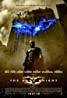

The Dark Knight None

The 7 most recommended movies to The Dark Knight are:




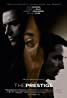

1 The Prestige None




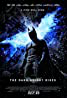

2 The Dark Knight Rises None




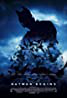

3 Batman Begins None




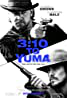

4 3:10 to Yuma None




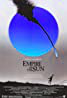

5 Empire of the Sun None




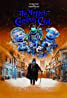

6 The Muppet Christmas Carol None




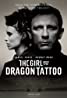

7 The Girl with the Dragon Tattoo None


In [23]:
#create a loop to print the first 7 similar movies
j = 0

movie_title = df[df.Movie_id == movie_id]['Title'].values[0]
poster_url = df[df.Movie_id == movie_id]['Poster_Link'].values[0]
image = io.imread(poster_url) 
print(movie_title, cv2_imshow(image))
d = []
print('\nThe 7 most recommended movies to', title, 'are:')
for item in sorted_scores[:7]:
  movie_title = df[df.Movie_id == item[0]]['Title'].values[0]
  poster_url = df[df.Movie_id == item[0]]['Poster_Link'].values[0]
  image = io.imread(poster_url)
  image_2 = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  final_frame = cv.hconcat((image, image_2))

  print('\n')   
  print(j+1, movie_title, cv2_imshow(image))
  j = j+1

